### High Salinity Shelf Water (HSSW) Event Detection and Production Rate Calculation 

The goal of this notebook is to try and rewrite Una's code in a reproducible and efficient manner that can be extended to new mooring data. Here, I will start by creating code identifying the HSSW production season. Then identify HSSW production events based on density measurements and filter events based on conditions related to wind speed, wind direction, AST pings, and current direction. HSSW production rates will be calculated for each event. 

In [24]:
# import packages 
import xarray as xr 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os as os

# package to help with HSSW event detection (counts contiguous events)
from scipy.ndimage import label

In [2]:
# load necessary datasets 
# For now, load the data that Una had saved which is already in a nice format 
# TO-DO later: make sure I know how to get raw data --> netcdf for all datasets! And understand any processing 
# Needed datasets: TNB Mooring data (temp, sal, AWAC, AST), AWS Manuela (wind speed + dir), Bremen SIC product 
directory = '/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/netCDFs'
varnames=[]
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        file=os.path.splitext(os.path.basename(filename))[0]
        varnames.append(file)

for name in varnames:
    globals()[name] = xr.open_dataset(directory+'/'+name+'.nc')
    print(name);

ice_thickness
awac_storm2
awacbackscatter
continental_withamplitude2
continental_withamplitude
8803_tilt
awac_ice_d1
cm300m
aqd300m2
was
awac_storm3
aws_data
awac_ice
AMSR_subset
aqd370m2
continental3
ldeo_mooring_tempsal_updated
aqd8803_tilt
aqd5388_tilt2
awac_ice10
awac_ice5
cm370m
AMSR_bremen_subset
aqd5388_tilt3
awac_ice4
tke85m_data
aqd230m
awaccur
continental2
tnb_coare_winter
waves
aqd200m
continental5
modisaqua_timeseries
awac_ice7
awac_storm
aqd5388_tilt4
cm230m
continental
seabirds
awac_ice3
aqd5388_tilt5
modisaqua_timeseries2
awac_ice2
tke50m_data
aqd5388_tilt
continental4
SBE4
aqd370m
awac_ice6
was2
modisterra_timeseries
tnb_coare_winter2
awac_ice_d2
aqd300m
awac_ice9
SBE
aqd230m2
awac_amp
awac_ice8
aws_data2
awac_vel
tnb_coare_winter3


In [3]:
sbe = ldeo_mooring_tempsal_updated

In [9]:
sbe.time.diff('time')

<xarray.DataArray 'time' (time: 527039)> Size: 4MB
array([60000000000, 60000000000, 60000000000, ..., 60000000000,
       60000000000, 60000000000], dtype='timedelta64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 4MB 2017-02-15T00:01:01 ... 2018-02-15T23:...

### Step 1. Identify HSSW Production Season and Crop 
The HSSW production season starts when potential density at the deepest sensor is within +/- 0.03 kg/m^3 of the shallowest sensor. Does this also apply to when the season ends? 

In [5]:
# crop sbe to remove deployment / recovery 
sbe = sbe.sel(time=slice('2017-02-15','2018-02-15'))

In [10]:
sbe_rolling_hourly = sbe.rolling(time=60).median()

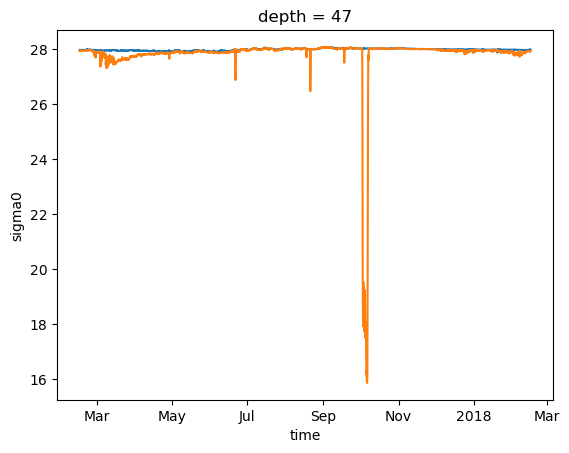

In [11]:
sbe_rolling_hourly.isel(depth=-1).sigma0.plot()
sbe_rolling_hourly.isel(depth=0).sigma0.plot()

In [12]:
shallow = sbe_rolling_hourly.sigma0.sel(depth=sbe_rolling_hourly.depth.min())
deep = sbe_rolling_hourly.sigma0.sel(depth=sbe_rolling_hourly.depth.max())


In [17]:
density_diff = abs(shallow - deep)  # Result: DataArray with time dimension



Text(0, 0.5, 'Absolute Potential Density Difference \n Shallow - Deep')

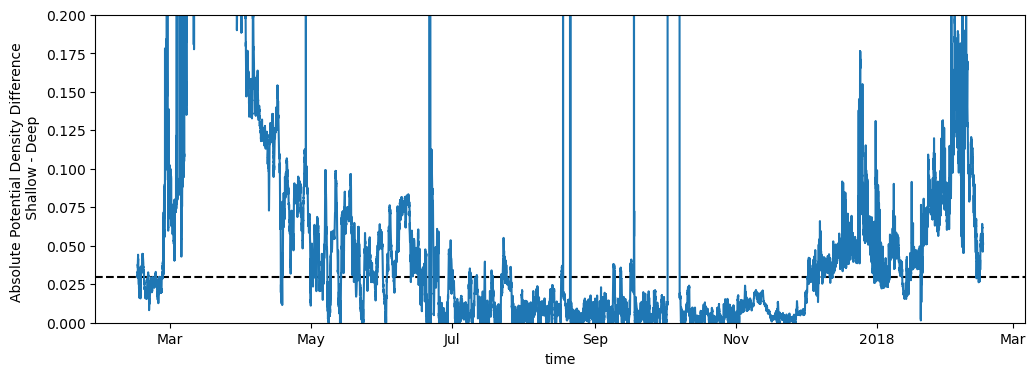

In [20]:
density_diff.plot(figsize=(12,4))
plt.ylim(0,0.2)
x_start, x_end = plt.xlim()
plt.xlim(x_start,x_end)

plt.hlines(y=0.03,xmin=x_start, xmax=x_end,color='k',linestyle='dashed')
plt.ylabel('Absolute Potential Density Difference \n Shallow - Deep')

### Step 2. Identify Potential HSSW Production Events Based on Potential Density 
- Flag time where potential density at shallowest sensor is greater than 1028 kg/m^3 (defining density for HSSW)
- Create segments that have at least a one hour duration

##### GOAL: 
- one xarray dataset per event, variables should include salinity, temperature, density, event start and stop 

In [83]:
def identify_event_sal(sal_da,sbe_ds,sal_threshold=34.8,duration_threshold = 60):
    """
    """
    sal_mask = sal_da > sal_threshold

    # 3. Label contiguous True regions (i.e. segments that meet the mask threshold) 
    labels, num_labels = label(sal_mask.values)

    # 4. Map labels back to xarray
    # this is a necessary step for slicing salinty array using mask 
    label_da = xr.DataArray(labels, coords=sal_da.coords, dims=["time"])

        # 5. Extract valid event IDs (at least 1 hour)
    events = []
    event_ids = np.unique(labels[labels > 0])  # exclude 0

    for eid in event_ids:
        eid_mask = (label_da == eid)
        duration = eid_mask.sum().item()
        
        if duration >= duration_threshold:
            event_salinity = sal_da.where(eid_mask, drop=True)  
            event = sbe_ds.sel(time=slice(event_salinity.time[0],event_salinity.time[-1]))
            events.append(event)

    return events


In [88]:
def identify_event_sigma(sigma_da,sbe_ds,sigma_threshold=28,duration_threshold = 60):
    """
    """
    sigma_mask = sigma_da > sigma_threshold

    # 3. Label contiguous True regions (i.e. segments that meet the mask threshold) 
    labels, num_labels = label(sigma_mask.values)

    # 4. Map labels back to xarray
    # this is a necessary step for slicing salinty array using mask 
    label_da = xr.DataArray(labels, coords=sigma_da.coords, dims=["time"])

        # 5. Extract valid event IDs (at least 1 hour)
    events = []
    event_ids = np.unique(labels[labels > 0])  # exclude 0

    for eid in event_ids:
        eid_mask = (label_da == eid)
        duration = eid_mask.sum().item()
        
        if duration >= duration_threshold:
            event_sigma = sigma_da.where(eid_mask, drop=True)  
            event = sbe_ds.sel(time=slice(event_sigma.time[0],event_sigma.time[-1]))
            events.append(event)

    return events

In [89]:
HSSW_events_sigma = identify_event_sigma(
    sigma_da = sbe_rolling_hourly.isel(depth=0).sigma0,
    sbe_ds = sbe_rolling_hourly
);

In [86]:
HSSW_events_sal = identify_event_sal(
    sal_da = sbe_rolling_hourly.isel(depth=0).practical_salinity,
    sbe_ds = sbe_rolling_hourly
);

### Step 3. Filter out HSSW Events Based on Wind, Current, and Sea Ice Conditions 
- Wind speeds must be at or exceeding 25 m/s
- Wind direction must be between 225 - 315 degrees 
- AST return pings must show transition from hard (> 70 dB) to soft reflectors (< 60 dB)
- Average current velocity must be offshore
- If any of these conditions are not met, then discard the event 

##### wind speed and direction requirement 

In [95]:
aws_data

<xarray.Dataset> Size: 3MB
Dimensions:   (time: 69838)
Coordinates:
  * time      (time) datetime64[ns] 559kB 2017-01-01T00:10:00 ... 2018-04-30T...
Data variables:
    wspd      (time) float64 559kB ...
    wdir      (time) float64 559kB ...
    atm_pres  (time) float64 559kB ...
    RH        (time) float64 559kB ...
    atm_temp  (time) float64 559kB ...

In [141]:
start = HSSW_events_sal[3].time[0]
end = HSSW_events_sal[3].time[-1]

In [142]:
wspd = aws_data.wspd.sel(time=slice(start,end))

In [143]:
wdir = aws_data.wdir.sel(time=slice(start,end))

In [144]:
wdir.min(),wdir.max()

(<xarray.DataArray 'wdir' ()> Size: 8B
 array(245.),
 <xarray.DataArray 'wdir' ()> Size: 8B
 array(275.))

In [145]:
wspd.mean()

<xarray.DataArray 'wspd' ()> Size: 8B
array(24.44444439)

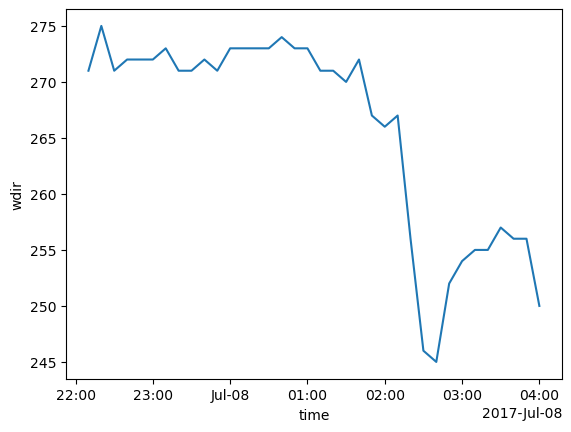

In [148]:
aws_data.wdir.sel(time=slice(start,end)).plot()

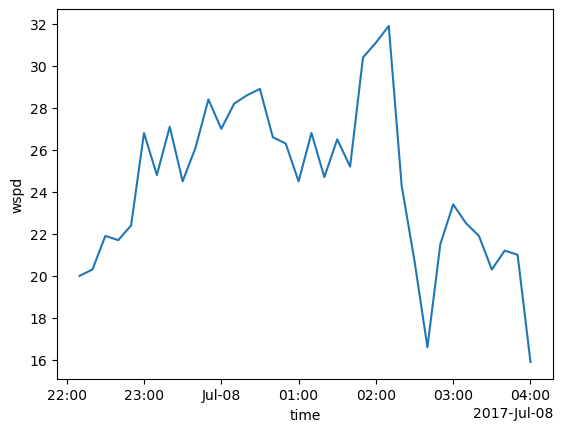

In [149]:
aws_data.wspd.sel(time=slice(start,end)).plot()

##### Ice thickness requirement 
Need to show transition from hard --> soft. Need to think about how to quantitatively capture that 

In [150]:
ice_thickness.d_quality.sel(time=slice(start,end)).min(), ice_thickness.d_quality.sel(time=slice(start,end)).max(),ice_thickness.d_quality.sel(time=slice(start,end)).mean()

(<xarray.DataArray 'd_quality' ()> Size: 8B
 array(21),
 <xarray.DataArray 'd_quality' ()> Size: 8B
 array(222),
 <xarray.DataArray 'd_quality' ()> Size: 8B
 array(111.08493329))

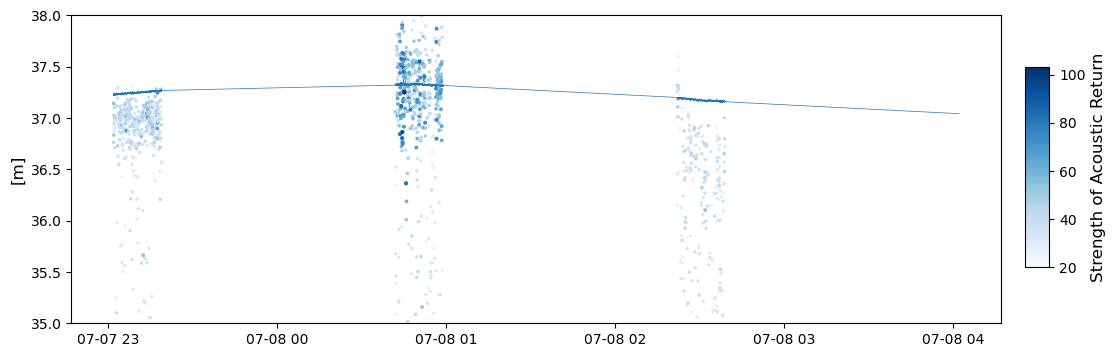

In [152]:
fig = plt.figure(figsize=(12,4))
plt.plot(ice_thickness.sel(time=slice(start,end)).time,ice_thickness.sel(time=slice(start,end)).instrument_depth-0.45,linewidth=0.5,label='Sea level')

im3 = plt.scatter(pd.to_datetime(ice_thickness.time.sel(time=slice(start,end)).values),
                  ice_thickness.d_tiltcor.sel(time=slice(start,end)),
                  c = ice_thickness.d_quality.sel(time=slice(start,end)),
                  vmin=20,
                  s=ice_thickness.d_quality.sel(time=slice(start,end))*0.05,
                  label='AST',cmap='Blues')#, vmin=110)

plt.ylim([35,38])
#plt.legend(fontsize=6, loc=4)
plt.ylabel('[m]', fontsize=12)

# plt.xaxis.set_ticklabels([])
# plt.xlim([was2.time.sel(time=slice(start,end))[0].values, was2.time.sel(time=slice(start,end))[-1].values])

cb_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im3, cax=cb_ax)
cbar.set_label('Strength of Acoustic Return',fontsize=12)
cbar.ax.tick_params(labelsize=10)

##### Current requirement 
STOPPED HERE! 

TO-DO:

Need to correct for magnetic declination first! 


Need to import magnetic declination .py file 


In [153]:
awaccur

<xarray.Dataset> Size: 20MB
Dimensions:    (distance: 20, time: 24855)
Coordinates:
  * distance   (distance) float64 160B 3.0 5.5 8.0 10.5 ... 43.0 45.5 48.0 50.5
  * time       (time) datetime64[ns] 199kB 2017-02-01T12:00:00 ... 2018-01-12...
Data variables:
    north      (distance, time) float64 4MB ...
    east       (distance, time) float64 4MB ...
    up         (distance, time) float64 4MB ...
    speed      (distance, time) float64 4MB ...
    direction  (distance, time) float64 4MB ...

### Step 4. Calculate HSSW Production Rate for Each Event 
- Calculate integrated mass of salt
- rate of brine rejection & scaled up to full polynya area
- production rate of HSSW for at each event and put in terms of yearly value 